# Example 5 -- Local Grid Refinement

In [1]:
# import Python packages used for this example
import pathlib as pl
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import flopy
from flopy.utils.lgrutil import Lgr
import geopandas as gp

In [2]:
domaingdf = gp.read_file('./data/ksa_outline.json').to_crs(8836)
bounds = domaingdf.bounds
domain =domaingdf.geometry.values[0]

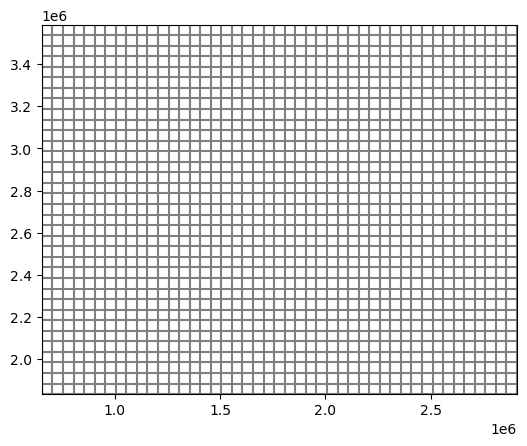

In [3]:
# define the model grid
Lx = bounds.maxx.values[0]-bounds.minx.values[0]
Ly = bounds.maxy.values[0]- bounds.miny.values[0]
nlayp = 1
nrowp = 35
delcp = np.ceil(Ly / nrowp) * np.ones(nrowp, dtype=float)
ncolp = np.ceil(Lx / delcp[0]).astype(int)
delrp = delcp[0] * np.ones(ncolp, dtype=float)
topp = 50 * np.ones((nrowp, ncolp), dtype=float)
botmp = -150 * np.ones((nlayp, nrowp, ncolp), dtype=float)
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)

# create modelgrid of parent
sg = flopy.discretization.StructuredGrid(
    nlay=nlayp,
    nrow=nrowp,
    ncol=ncolp,
    delr=delrp,
    delc=delcp,
    top=topp,
    botm=botmp,
    xoff=bounds.minx.values[0],
    yoff=bounds.miny.values[0],angrot=0, crs=8836
)
sg.plot()

## let's refine around the City of Riyadh again

In [4]:
riyadh = gp.read_file('./data/citylocation.geojson').to_crs(domaingdf.crs)
rbuf = riyadh.buffer(1e5)
rbounds = rbuf.bounds
rbounds

/Users/mnfienen/miniforge3/envs/flopyswf/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/Users/mnfienen/miniforge3/envs/flopyswf/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


,minx,miny,maxx,maxy
0,1.796457e+06,2.703795e+06,1.996457e+06,2.903795e+06


In [5]:
gi = flopy.utils.GridIntersect(sg)
insetlox = gi.intersect(rbuf.geometry[0])
for i,j in insetlox.cellids:
    idomainp[:,i,j]=0

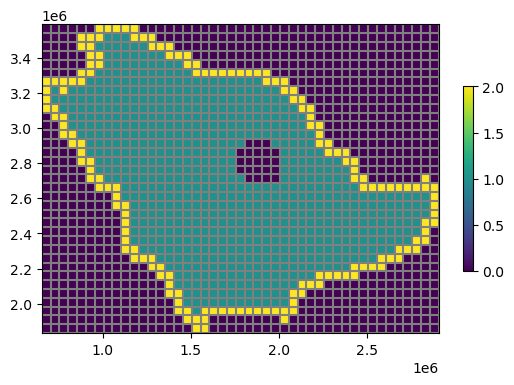

In [6]:
# create a flopy Lgr object for constructing a child grid
lgr = Lgr(
    nlayp,
    nrowp,
    ncolp,
    delrp,
    delcp,
    topp,
    botmp,
    idomainp,
    ncpp=1,
    ncppl=[1],
    xllp=bounds.minx.values[0],
    yllp=bounds.miny.values[0]
)

# build an idomain array for the parent grid
idomain = np.zeros((nlayp, nrowp, ncolp), dtype=int)
gi = flopy.utils.GridIntersect(sg)

# inside domain polygon
ixp = gi.intersect(domain)
for i, j in ixp["cellids"]:
    idomain[:, i, j] = 1

# touching domain polygon
ls = LineString([p for p in domain.exterior.coords])    
ixl = gi.intersect(ls)
for i, j in ixl["cellids"]:
    idomain[:, i, j] = 2
    
idomain[np.where(idomainp == 0)] = 0

# make a plot
pmv = flopy.plot.PlotMapView(modelgrid=sg)
pmv.plot_grid()
cb = pmv.plot_array(idomain)
plt.colorbar(cb, shrink=.5)

In [7]:
# create the flopy representation of the MODFLOW simulation
ws = './ex5'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)

# parent model
name = "parent"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=nlayp, 
    nrow=nrowp, 
    ncol=ncolp, 
    delr=delrp, 
    delc=delcp,
    top=topp,
    botm=botmp,
    idomain=idomain,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)
chdspd = [[(0, *j), 100.] for j in ixl["cellids"]]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.0001)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
gwf_parent = gwf

# child model
name = "child"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, 
                           save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    gwf, 
    nlay=lgr.nlay, 
    nrow=lgr.nrow, 
    ncol=lgr.ncol, 
    delr=lgr.delr, 
    delc=lgr.delc,
    top=lgr.top,
    botm=lgr.botm,
    xorigin=lgr.xll,
    yorigin=lgr.yll,
)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.1)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
gwf_child = gwf

# setup the exchange, which connects the parent and child models
exchangedata = lgr.get_exchange_data(
    angldegx=True, 
    cdist=True
)
exg = flopy.mf6.ModflowGwfgwf(sim, 
                        exgmnamea="parent",
                        exgmnameb="child",
                        xt3d=True,
                        nexg=len(exchangedata),
                        auxiliary=["ANGLDEGX", "CDIST"],
                        exchangedata=exchangedata)

In [8]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package mymodel.gwfgwf...
  writing model parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 163 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
  writing model child...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package oc...


In [9]:
# run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

(False, [])

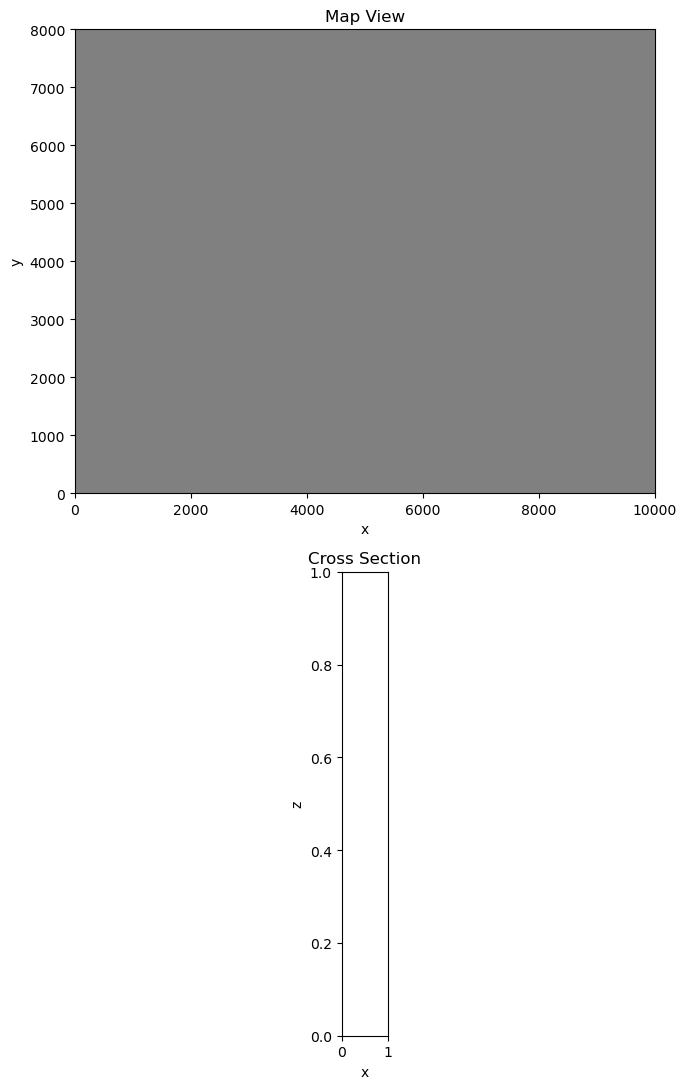

In [10]:
# create a plot of the simulation results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")

for igrid, gwf in enumerate([gwf_parent, gwf_child]):
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    if igrid == 0:
        # parent
        pmv.plot_inactive(color_noflow="gray")
        pmv.plot_bc(ftype="CHD")
        pmv.plot_vector(qx, qy, normalize=True, color="black")
    if igrid == 1:
        # child
        c = pmv.plot_array(head, masked_values=[1.e30])
    pmv.plot_grid(colors='black', linewidths=0.5)
    pmv.contour_array(head, colors="blue")
ax.set_xlim(0, 10000)
ax.set_ylim(0, 8000)

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
for igrid, gwf in enumerate([gwf_parent, gwf_child]):
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(0, 5000), (10000, 5000)]}, geographic_coords=True)
    # if igrid == 0:
    #     pxs.plot_inactive(color_noflow="gray")
    # c = pxs.plot_array(head, masked_values=[1.e30], head=head)
    # pxs.plot_grid(colors='black', linewidths=0.5)
# ax.set_xlim(0, 10000)
# ax.set_ylim(-100, 50)
plt.tight_layout()